In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transactional-ecommerce/click_stream.csv
/kaggle/input/transactional-ecommerce/product.csv
/kaggle/input/transactional-ecommerce/customer.csv
/kaggle/input/transactional-ecommerce/transactions.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast  #to convert the event metadat to dict
import json

pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 1000)  # Expand output width
#ignore the warning 
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [3]:
#load data

data_path = '/kaggle/input/transactional-ecommerce/'
cust_data = pd.read_csv(data_path + 'customer.csv')
trans_data = pd.read_csv(data_path + 'transactions.csv')
# click_data = pd.read_csv(data_path + 'click_stream.csv',nrows=500000)

#merge the data
df = trans_data.merge(cust_data, on="customer_id", how="left")
df.shape

(852584, 28)

# Data quality checks and general EDA

In [4]:
df.isnull().sum()

created_at                     0
customer_id                    0
booking_id                     0
session_id                     0
product_metadata               0
payment_method                 0
payment_status                 0
promo_amount                   0
promo_code                526048
shipment_fee                   0
shipment_date_limit            0
shipment_location_lat          0
shipment_location_long         0
total_amount                   0
first_name                     0
last_name                      0
username                       0
email                          0
gender                         0
birthdate                      0
device_type                    0
device_id                      0
device_version                 0
home_location_lat              0
home_location_long             0
home_location                  0
home_country                   0
first_join_date                0
dtype: int64

In [5]:
#transaction period
trans_data["created_at"] = pd.to_datetime(trans_data["created_at"])  # Ensure datetime format
start_time = trans_data["created_at"].min()
end_time = trans_data["created_at"].max()

print(f"Transaction period: {start_time} to {end_time}")


Transaction period: 2016-06-30 23:18:44.792905+00:00 to 2022-07-31 23:59:45.821469+00:00


In [6]:
#time period of the hisorical customer data   ----> same timeframe
cust_data["first_join_date"] = pd.to_datetime(cust_data["first_join_date"])  # Ensure datetime format
start_time = cust_data["first_join_date"].min()
end_time = cust_data["first_join_date"].max()

print(f"Customer interaction period: {start_time} to {end_time}")


Customer interaction period: 2016-06-30 00:00:00 to 2022-07-31 00:00:00


# Customer behavioral analysis

In [7]:
#number of new and repeated customers
one_time_customers = df.groupby('customer_id').filter(lambda x: len(x) == 1)
repeated_customers = df.groupby('customer_id').filter(lambda x: len(x) > 1)

df['customer_type'] = np.where(df['customer_id'].isin(one_time_customers['customer_id']),'new','repeated')
# Create a pivot table counting the number of unique customer_ids for each type
pivot_table = df.pivot_table(index='customer_type', values='customer_id', aggfunc=pd.Series.nunique)
pivot_table

,customer_id
customer_type,
new,10241
repeated,40464


In [8]:
#Aggregating customer-level metrics from transaction data
df["promo_code"].replace(np.nan,"", inplace=True)
customer_metrics = df.groupby('customer_id').agg(
    customer_type =('customer_type', 'first'),
    purchase_frequency=('booking_id', 'count'),  # Number of purchases
    total_spent=('total_amount', 'sum'),  # Total amount spent
    average_order_value=('total_amount', 'mean'),  # AOV (Total Spend / Purchase Count)
    discount_codes=('promo_code', lambda x: ', '.join(filter(None, x.unique()))),  # Unique discount codes as string
    total_promo_amount=('promo_amount', 'sum') # Total discount amount used

).reset_index()

# Merge with customer_metrics to include first buy date
customer_metrics = customer_metrics.merge(cust_data, on='customer_id', how='left')
customer_metrics.head()

,customer_id,customer_type,purchase_frequency,total_spent,average_order_value,discount_codes,total_promo_amount,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date
0,3,repeated,51,21265889,416978.215686,"WEEKENDMANTAP, WEEKENDSERU, LIBURDONG",131082,Ganep,Mustofa,76412a05-64ab-4e8c-b275-a7181b5c0b9d,76412a05_64ab_4e8c_b275_a7181b5c0b9d@startupca...,M,1986-07-12,Android,dd0c9125-c645-4b82-8d4b-a1cd1e2dba20,Android 3.2.3,-6.151858,106.945839,Jakarta Raya,Indonesia,2018-08-25
1,8,repeated,7,3898561,556937.285714,WEEKENDSERU,7699,Nilam,Fujiati,848e59ba-e4f7-480a-bd36-e31fd4a03f83,848e59ba_e4f7_480a_bd36_e31fd4a03f83@startupca...,F,2000-07-19,Android,f8a01a56-a55f-4a33-9ad9-2fa69137f7ff,Android 2.2,0.970013,124.816832,Sulawesi Utara,Indonesia,2021-02-13
2,9,repeated,6,2638665,439777.500000,,0,Hesti,Purwanti,8abe001b-5d2e-4af1-8c12-0b44309d38ca,8abe001b_5d2e_4af1_8c12_0b44309d38ca@startupca...,F,2006-04-05,Android,ece472e7-ab36-4d85-aca0-2df8491189fe,Android 5.1.1,-6.035939,106.747580,Jakarta Raya,Indonesia,2021-06-26
3,11,new,1,197533,197533.000000,XX2022,9492,Luwar,Permadi,5771c240-e53e-448a-8938-b1fc7a2c120f,5771c240_e53e_448a_8938_b1fc7a2c120f@zakyfound...,M,1993-07-27,Android,8c8aa601-df75-473a-aaeb-c8d027d543d9,Android 4.3,1.189610,117.064209,Kalimantan Timur,Indonesia,2022-03-06
4,15,repeated,5,2134870,426974.000000,"BUYMORE, WEEKENDMANTAP, XX2022",16362,Tari,Hassanah,fa713b1b-3f29-41a5-abba-bba5df3c9290,fa713b1b_3f29_41a5_abba_bba5df3c9290@startupca...,F,1983-06-28,Android,aea56e94-eea4-462f-b717-bdf8722047b7,Android 4.3,-7.321196,106.653088,Jawa Barat,Indonesia,2019-09-28


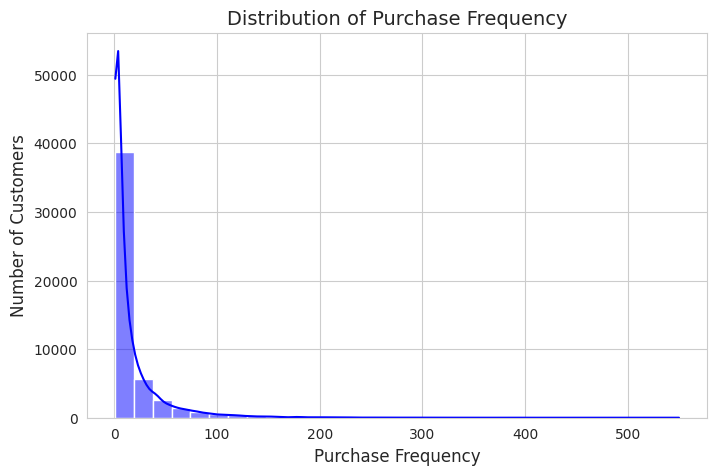

In [9]:
#plot of purchase frequency  ---> So most of them are new or those who have purchased very less number of times


# Set style
sns.set_style("whitegrid")

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(customer_metrics['purchase_frequency'], bins=30, kde=True, color='blue')

# Labels and title
plt.xlabel("Purchase Frequency", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.title("Distribution of Purchase Frequency", fontsize=14)

# Show plot
plt.show()


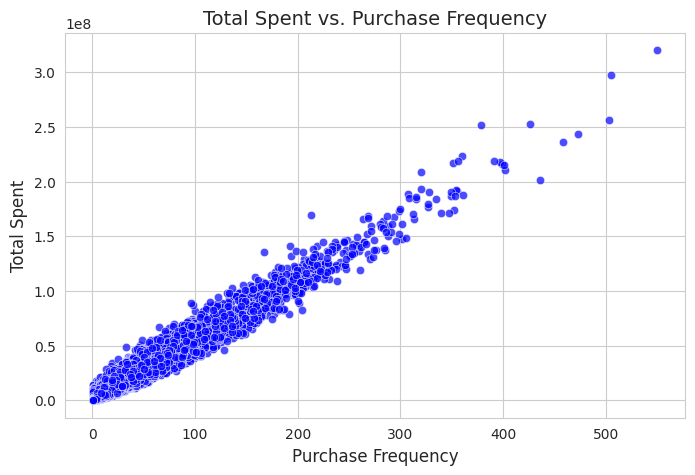

In [10]:
#Total Spent vs. Purchase Frequency (Scatter Plot) ---> can see strong correlation
# ---> data is coherent with our expectations


# Set style
sns.set_style("whitegrid")

# Create scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=customer_metrics, x='purchase_frequency', y='total_spent', alpha=0.7, color='blue')

# Labels and title
plt.xlabel("Purchase Frequency", fontsize=12)
plt.ylabel("Total Spent", fontsize=12)
plt.title("Total Spent vs. Purchase Frequency", fontsize=14)

# Show plot
plt.show()


In [11]:
customer_metrics.to_csv("customer_metics.csv")

### Exploring the customer journey through click stream data

In [12]:
click_data = pd.read_csv(data_path + 'click_stream.csv')
click_data.shape


(12833602, 6)

In [13]:
click_data.head()

,session_id,event_name,event_time,event_id,traffic_source,event_metadata
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,"{'product_id': 15315, 'quantity': 4, 'item_pri..."
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,{'payment_status': 'Success'}


In [14]:
#touchpoint period  ---> consistent with the transaction and customer historical data time period
click_data["event_time"] = pd.to_datetime(click_data["event_time"])  # Ensure datetime format
start_time = click_data["event_time"].min()
end_time = click_data["event_time"].max()

print(f"Touchpoint period: {start_time} to {end_time}")


Touchpoint period: 2016-06-30 22:59:36.254358+00:00 to 2022-08-01 00:49:59.408424+00:00


In [15]:
#check if the session_id is consistent across dates for a customer 
#to see if it can be used as a customer identifier  
#---> the session_id doesnt change across dates
click_data[click_data["session_id"]=="5b675618-09be-43c6-8653-bb68a0831049"].head(20)

,session_id,event_name,event_time,event_id,traffic_source,event_metadata
112,5b675618-09be-43c6-8653-bb68a0831049,HOMEPAGE,2019-11-12 01:52:31.425431+00:00,b24b379d-2042-4014-8c7a-d904d63ddede,MOBILE,NaN
113,5b675618-09be-43c6-8653-bb68a0831049,ADD_TO_CART,2019-11-12 03:00:47.425431+00:00,f4cb4068-0349-4c2f-af9b-8c7ca9925cd0,MOBILE,"{'product_id': 25446, 'quantity': 3, 'item_pri..."
114,5b675618-09be-43c6-8653-bb68a0831049,BOOKING,2019-11-12 13:15:21.425431+00:00,97b5aa09-7708-4bec-84e1-81d81d3d9394,MOBILE,{'payment_status': 'Success'}
115,5b675618-09be-43c6-8653-bb68a0831049,HOMEPAGE,2019-11-12 03:00:18.425431+00:00,b998a986-159b-48ee-9fec-6c478bed218e,MOBILE,NaN
116,5b675618-09be-43c6-8653-bb68a0831049,SCROLL,2019-11-12 04:09:41.425431+00:00,de519658-aa19-4c06-a884-4a4feb15d971,MOBILE,NaN
117,5b675618-09be-43c6-8653-bb68a0831049,SCROLL,2019-11-12 05:17:02.425431+00:00,e3e3d463-d76b-4814-bd71-2598cb02b448,MOBILE,NaN
118,5b675618-09be-43c6-8653-bb68a0831049,CLICK,2019-11-12 06:25:42.425431+00:00,65f4880a-0196-4e4d-aa2b-107091dfa018,MOBILE,NaN
119,5b675618-09be-43c6-8653-bb68a0831049,CLICK,2019-11-12 07:34:25.425431+00:00,2f2a3122-b4f6-4536-abea-2da417feecc7,MOBILE,NaN
120,5b675618-09be-43c6-8653-bb68a0831049,SCROLL,2019-11-12 08:43:12.425431+00:00,6c331387-3906-431b-9819-38fe64ad026a,MOBILE,NaN
121,5b675618-09be-43c6-8653-bb68a0831049,CLICK,2019-11-12 09:50:33.425431+00:00,e09f4ae8-ee58-40e0-984d-868a798a7535,MOBILE,NaN


In [16]:
# Identify sessions with multiple traffic sources
#each session_id is for a single traffic source  ---> check with mentor
multi_source_sessions = click_data.groupby("session_id")["traffic_source"].nunique() > 1

# Filter click_data for only those sessions
filtered_click_data = click_data[click_data["session_id"].isin(multi_source_sessions.index[multi_source_sessions])]

print(filtered_click_data)


Empty DataFrame
Columns: [session_id, event_name, event_time, event_id, traffic_source, event_metadata]
Index: []


### Check if event_names = BOOKING has only payment:success on the event_metadata  ----> no, there are some payment:failed as well

-->hence we cannot assume that BOOKING means a completed transaction. Instead, we need to explicitly check for PAYMENT_SUCCESS

In [17]:
#derive a new column where the touchpoints lead to a successful payment
# Convert the column to dictionaries
click_data["event_metadata"] = click_data["event_metadata"].replace(np.nan, "{}").apply(ast.literal_eval)

booking_df = click_data[click_data["event_name"] == "BOOKING"]

# Extract payment_status (if exists, else return None)
booking_df["payment_status"] = booking_df["event_metadata"].apply(lambda x: x.get("payment_status", None))

# Check if all 'BOOKING' rows have payment_status = 'Success'
all_success = (booking_df["payment_status"] == "Success").all()

# Print result
print(f"All BOOKING events have payment_status = Success: {all_success}")


All BOOKING events have payment_status = Success: False


## Cohort analysis

 ### conversion rates in a year ----> typically customers convert during initial days ---> 83% of users converted within 25 days of signing up
* around 60%  convert within first 5 days, then there is a sharp decline

* Retention strategies needed after 25 days → Users who haven’t converted by now may need special offers, personalized nudges, or exclusive deals to convert.


In [18]:

# Extract payment status from metadata
click_data["payment_status"] = click_data["event_metadata"].apply(lambda x: x.get("payment_status", None))

# Use groupby().agg() for efficient computation
session_analysis = click_data.groupby("session_id").agg(
    event_sequence=("event_name", lambda x: " → ".join(x.astype(str))),  # Efficient string join
    payment_success=("payment_status", lambda x: int("Success" in x.values)),  # Check for any "Success"
    first_event_date=("event_time", "min"),  # Get first event timestamp
).reset_index()

# Optimized way to get first payment success date (Avoids `apply()`)
first_payment_df = (
    click_data[click_data["payment_status"] == "Success"]
    .groupby("session_id", as_index=False)["event_time"]
    .min()
    .rename(columns={"event_time": "first_payment_success_date"})
)

# Merge instead of apply() for better performance
session_analysis = session_analysis.merge(first_payment_df, on="session_id", how="left")



In [19]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 2.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 6.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=25e998afd021ac47dac2a98588b230243a6f92cfaa2259addac08f4f0b420270
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


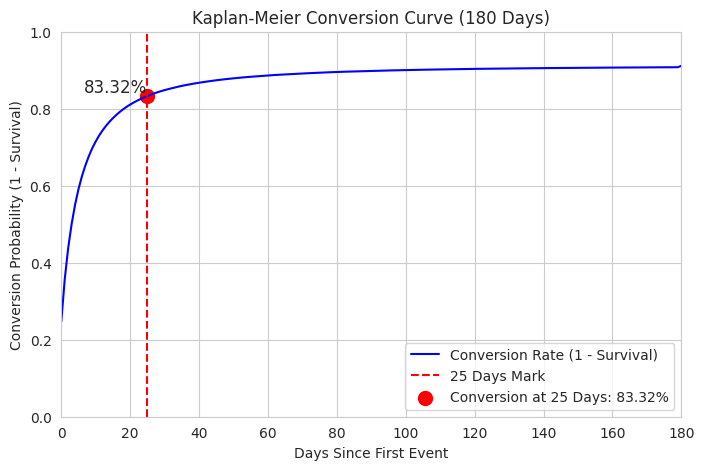

📌 At 25 days, 83.32% of users have converted.


In [20]:
from lifelines import KaplanMeierFitter
# Define Time Until Conversion (Duration)
session_analysis["time_to_conversion"] = (session_analysis["first_payment_success_date"] - 
                                          session_analysis["first_event_date"]).dt.days

# Handle Missing Values (Censoring)
session_analysis["time_to_conversion"].fillna(session_analysis["time_to_conversion"].max(), inplace=True)

# Cap at 365 days
session_analysis["time_to_conversion"] = session_analysis["time_to_conversion"].clip(upper=180)

# Filter data within 180 days
session_analysis = session_analysis[session_analysis["time_to_conversion"] <= 180]

# Kaplan-Meier Model
kmf = KaplanMeierFitter()
kmf.fit(durations=session_analysis["time_to_conversion"], event_observed=session_analysis["payment_success"])

# Get survival probabilities and convert to conversion probabilities
time_points = kmf.timeline
survival_probabilities = kmf.survival_function_.values.flatten()
conversion_probabilities = 1 - survival_probabilities  # Convert survival to conversion rate

# Get conversion probability at 25 days
conversion_rate_25_days = 1 - kmf.predict(25)

# Plot Conversion Function
plt.figure(figsize=(8, 5))
plt.plot(time_points, conversion_probabilities, label="Conversion Rate (1 - Survival)", color="blue")
plt.axvline(x=25, color="red", linestyle="dashed", label="25 Days Mark")
plt.scatter(25, conversion_rate_25_days, color="red", s=100, label=f"Conversion at 25 Days: {conversion_rate_25_days:.2%}")

# Annotate conversion rate at 25 days
plt.text(25, conversion_rate_25_days, f"{conversion_rate_25_days:.2%}", verticalalignment="bottom", horizontalalignment="right", fontsize=12)

# Customize labels
plt.title("Kaplan-Meier Conversion Curve (180 Days)")
plt.xlabel("Days Since First Event")
plt.ylabel("Conversion Probability (1 - Survival)")
plt.xlim(0, 180)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# Print result
print(f"📌 At 25 days, {conversion_rate_25_days:.2%} of users have converted.")

In [21]:
session_analysis.iloc[0:100,:].to_csv("customer_behaviour.csv")

# Promotion level analysis

In [22]:
df.columns

Index(['created_at', 'customer_id', 'booking_id', 'session_id', 'product_metadata', 'payment_method', 'payment_status', 'promo_amount', 'promo_code', 'shipment_fee', 'shipment_date_limit', 'shipment_location_lat', 'shipment_location_long', 'total_amount', 'first_name', 'last_name', 'username', 'email', 'gender', 'birthdate', 'device_type', 'device_id', 'device_version', 'home_location_lat', 'home_location_long', 'home_location', 'home_country', 'first_join_date', 'customer_type'], dtype='object')

In [23]:
#customers who aren't in the transactions data  
missing_customers = cust_data.loc[~cust_data["customer_id"].isin(trans_data["customer_id"]), "customer_id"].unique()
missing_customers.shape

(49295,)

In [24]:
df.groupby("promo_code")["booking_id"].count()

promo_code
                 526048
AZ2022            89227
BUYMORE           66835
LIBURDONG         20965
SC2022            11271
STARTUP           11105
WEEKENDMANTAP     20448
WEEKENDSERU       61941
XX2022            44744
Name: booking_id, dtype: int64

In [25]:
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

# **Step 1**: Remove NULL promo_codes 
df["promo_code"] = df["promo_code"].replace("",np.nan)
df_cleaned = df.dropna(subset=["promo_code"])

# **Step 2**: Group by promo_code and aggregate required metrics
promo_summary = df_cleaned.groupby("promo_code").agg(
    frequency=("promo_code", "count"),  # Number of times used
    start_date=("created_at", "min"),  # First use date
    end_date=("created_at", "max"),  # Last use date
    duration=("created_at", lambda x: (x.max() - x.min()).days),  # Duration in days
    total_sales=("total_amount", "sum"),  # Total sales amount
    avg_promo_amount=("promo_amount", "mean")  # Average promo discount
).reset_index()


In [26]:
promo_summary.to_csv("promotional_data.csv")

# product level data

### We are looking at 44447 unique products sold on the site

In [27]:
# Open the file and read line by line  
cust_data = pd.read_csv(data_path + 'customer.csv')

with open(data_path + 'product.csv', "r") as f:
    lines = f.readlines()  # Read all lines

# Process each line and fix extra column issue
cleaned_data = []
for line in lines:
    cols = line.strip().split(",")  # Split by comma
    if len(cols) > 10:  # If there's an 11th column
        cols[9] = cols[9] + ", " + cols[10]  # Merge into 10th column
        cols = cols[:10]  # Trim to first 10 columns
    cleaned_data.append(cols)

# Convert cleaned data into a DataFrame
product_data = pd.DataFrame(cleaned_data, columns=['product_id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName'])  # Replace with actual column names

product_data.shape


(44447, 10)

In [ ]:
#year of each product -- range

In [28]:
#transforming to get a better product and transaction data combined

# Function to safely convert strings to lists of dictionaries
def safe_eval(metadata):
    try:
        return json.loads(metadata.replace("'", '"'))  # Convert single quotes to double quotes for valid JSON
    except json.JSONDecodeError:
        return []  # Return empty list if conversion fails

# Convert product column to list of dictionaries
trans_data["product_metadata"] = trans_data["product_metadata"].apply(safe_eval)

# Explode to create separate rows for each product
trans_data_exploded = trans_data.explode('product_metadata').reset_index(drop=True)

# Normalize dictionary values into separate columns
trans_data_new = trans_data_exploded.join(pd.json_normalize(trans_data_exploded['product_metadata']))

# Drop the original product column
trans_data_new = trans_data_new.drop(columns=['product_metadata']).reset_index(drop=True)

#product data product_id contains "id" for the product id column, which throws error while converting to int , it is dropped
product_data["product_id"] = pd.to_numeric(product_data["product_id"], errors="coerce")  # Convert invalid values to NaN
product_data = product_data.dropna(subset=["product_id"])  # Drop rows where product_id is NaN
product_data["product_id"] = product_data["product_id"].astype(int)  # Convert to integer
product_data.shape

(44446, 10)

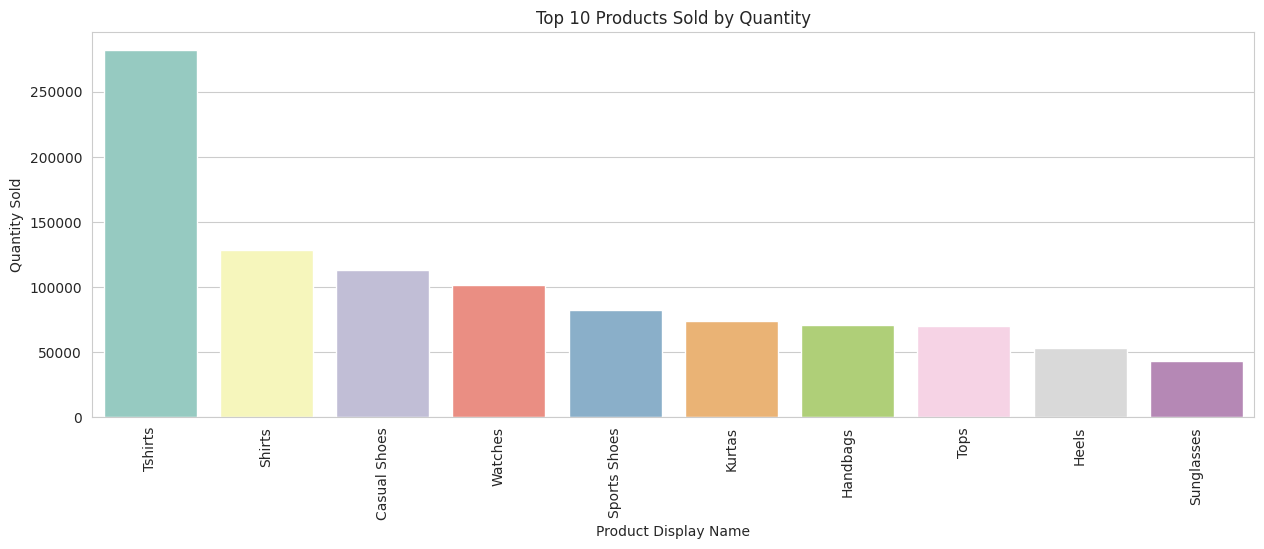

In [29]:
#new data for product and transaction data combined
df_transaction_products = pd.merge(trans_data_new, product_data, on='product_id',how = "left")


In [63]:
df_transaction_products.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,shipment_days
0,2018-07-29 15:22:01.458193+00:00,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03 05:07:24.812676+00:00,-8.227893,111.969107,199832,54728,1,191247,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2012,Casual,Vans Men Black Shoes,4
1,2018-07-30 12:40:22.365620+00:00,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03 01:29:03.415705+00:00,3.013470,107.802514,155526,16193,1,145526,Men,Apparel,Topwear,Sweaters,Green,Fall,2011,Casual,Puma Men Knitted Vest Green Sweater,3
2,2018-09-15 11:51:17.365620+00:00,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,2018-09-18 08:41:49.422380+00:00,-2.579428,115.743885,550696,53686,4,135174,Women,Accessories,Bags,Handbags,Purple,Summer,2012,Casual,Kiara Women Purple & Yellow Handbag,2
3,2018-11-01 11:23:48.365620+00:00,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,2018-11-05 17:42:27.954235+00:00,-3.602334,120.363824,271012,20228,1,271012,Women,Apparel,Topwear,Sweaters,Red,Fall,2011,Casual,Wrangler Women Cable Red Sweater,4
4,2018-12-18 11:20:30.365620+00:00,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,2018-12-23 17:24:07.361785+00:00,-3.602334,120.363824,198753,55220,1,198753,Women,Personal Care,Lips,Lip Liner,Brown,Spring,2017,Casual,Lakme Absolute Forever Silk Chestnut Lip Liner 03,5


In [64]:
# Convert shipment_date_limit and created_at to timedelta (Shipment Processing Time)
df_transaction_products['created_at'] = pd.to_datetime(df_transaction_products['created_at'], errors='coerce')
df_transaction_products['shipment_date_limit'] = pd.to_datetime(df_transaction_products['shipment_date_limit'], errors='coerce')
df_transaction_products["shipment_days"] = (df_transaction_products["shipment_date_limit"] - df_transaction_products["created_at"]).dt.days
df_transaction_products["product_id"] = df_transaction_products["product_id"].astype(str)

# Group by Product ID
product_summary = df_transaction_products.groupby("product_id").agg(
    total_sales=("total_amount", "sum"),  # Total Sales
    total_orders=("quantity", "sum"),  # Total Orders
    avg_quantity=("quantity", "mean"),  # Average Quantity Purchased
    avg_item_price=("item_price", "mean"),  # Average Item Price
    total_promo_discount=("promo_amount", "sum"),  # Total Promo Discount
    promo_usage_ratio=("promo_code", lambda x: x.notnull().mean()),  # % of orders with promo
    avg_shipment_fee=("shipment_fee", "mean"),  # Average Shipment Fee
    avg_shipment_days=("shipment_days", "mean"),  # Avg Days to Deliver
    unique_customers=("customer_id", "nunique"),  # Unique Customers,
    product_name=("productDisplayName", lambda x: x.mode()[0]),  #  product name
    top_category=("masterCategory", lambda x: x.mode()[0]),  # product Category
    top_color=("baseColour", lambda x: x.mode()[0]),  # product Color
    top_season=("season", lambda x: x.mode()[0])  # product Season
).reset_index()



In [65]:
product_summary.to_csv("product_summary.csv")

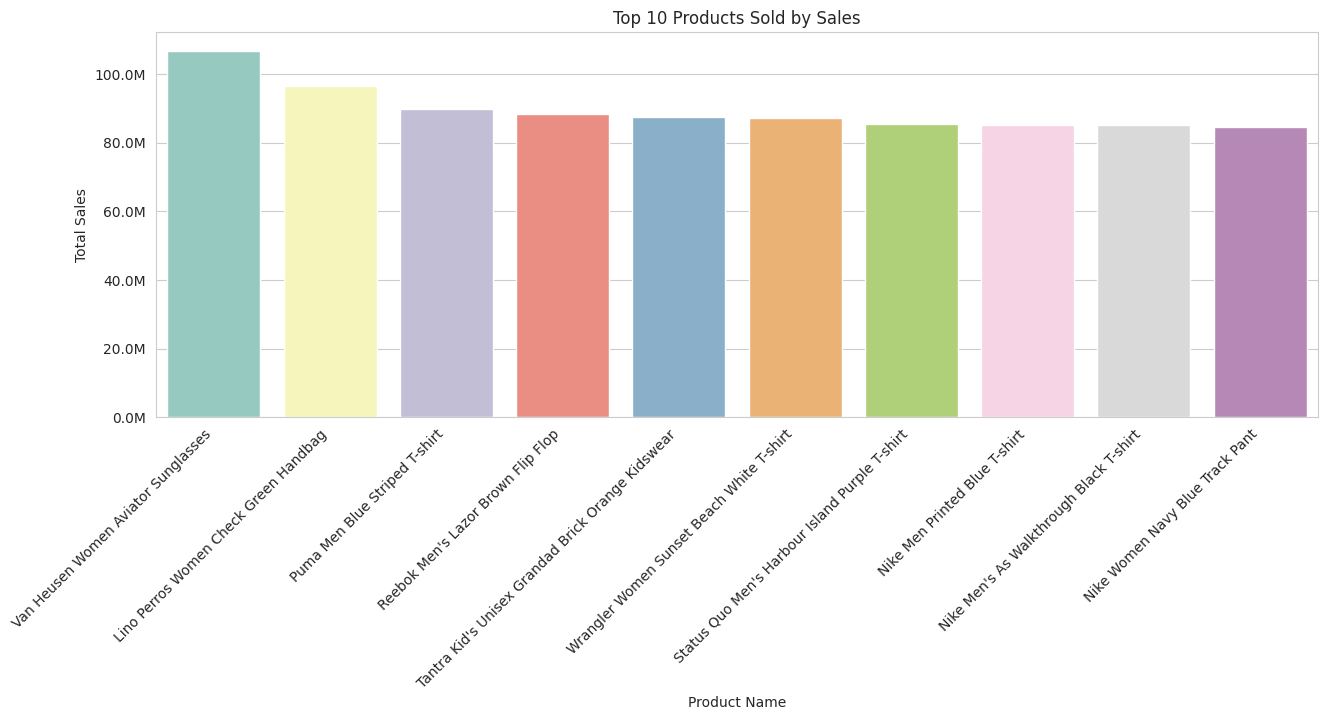

In [66]:
from matplotlib.ticker import FuncFormatter

# Select top 10 products by total sales
top_10_products = product_summary.sort_values(by="total_sales", ascending=False).head(10)

# Plot
plt.figure(figsize=(15, 5))
ax = sns.barplot(x="product_name", y="total_sales", data=top_10_products, palette="Set3")

# Format y-axis to show values in millions
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M'))

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha="right")

# Adding labels for clarity
plt.title('Top 10 Products Sold by Sales')
plt.xlabel('Product Name')
plt.ylabel('Total Sales')

# Show plot
plt.show()


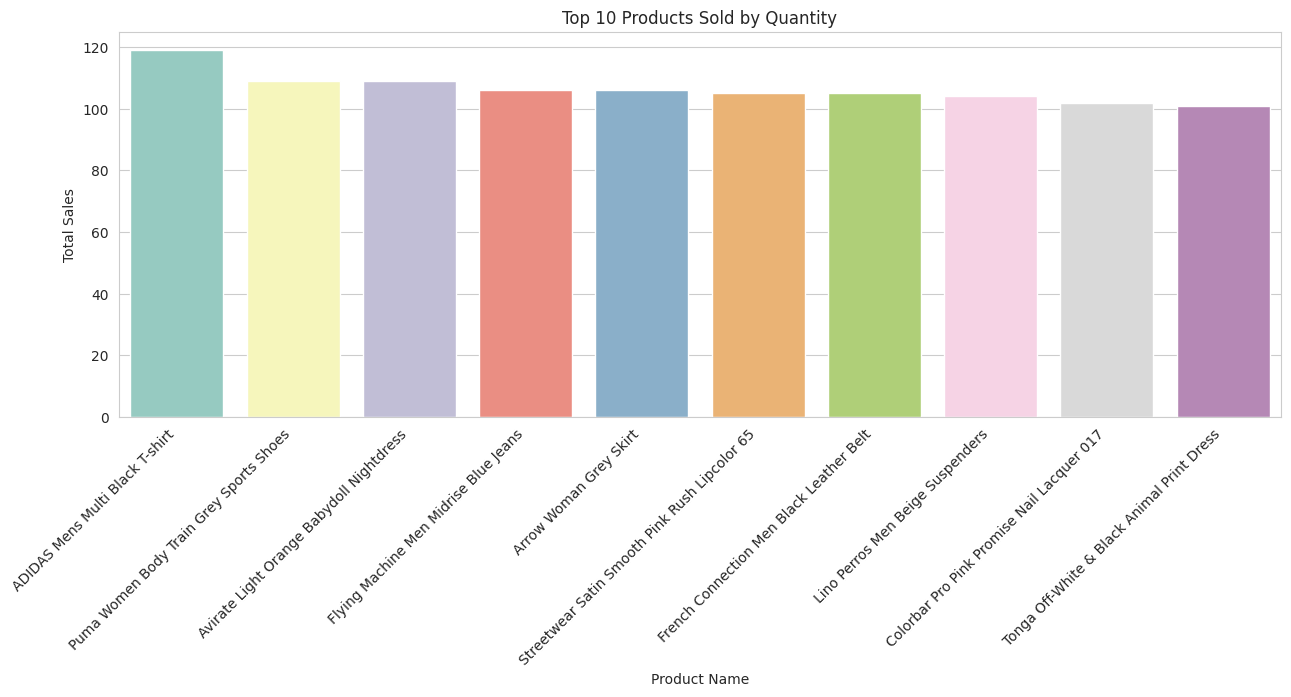

In [67]:

# Select top 10 products by total orders
top_10_products = product_summary.sort_values(by="total_orders", ascending=False).head(10)

# Plot
plt.figure(figsize=(15, 5))
ax = sns.barplot(x="product_name", y="total_orders", data=top_10_products, palette="Set3")


# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha="right")

# Adding labels for clarity
plt.title('Top 10 Products Sold by Quantity')
plt.xlabel('Product Name')
plt.ylabel('Total Sales')

# Show plot
plt.show()


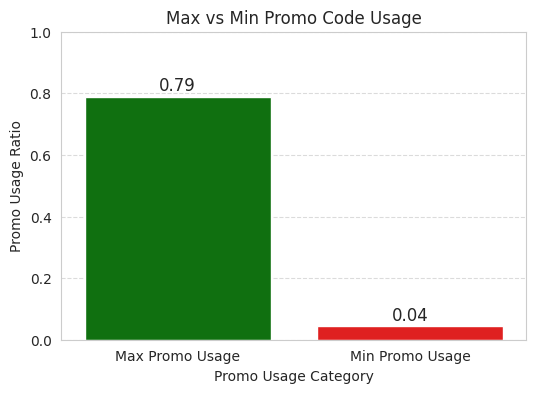

In [69]:
# Find max and min promo usage ratio
max_promo_product = product_summary.loc[product_summary["promo_usage_ratio"].idxmax()]
min_promo_product = product_summary.loc[product_summary["promo_usage_ratio"].idxmin()]

# Create a dataframe for visualization
promo_extremes = pd.DataFrame({
    "product_id": [max_promo_product["product_id"], min_promo_product["product_id"]],
    "promo_usage_ratio": [max_promo_product["promo_usage_ratio"], min_promo_product["promo_usage_ratio"]],
    "Label": ["Max Promo Usage", "Min Promo Usage"]
})

# Plot the data
plt.figure(figsize=(6, 4))
sns.barplot(x="Label", y="promo_usage_ratio", data=promo_extremes, palette=["green", "red"])

# Customize labels
plt.title("Max vs Min Promo Code Usage")
plt.xlabel("Promo Usage Category")
plt.ylabel("Promo Usage Ratio")
plt.ylim(0, 1)  # Since the ratio is between 0 and 1
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Annotate values
for index, row in promo_extremes.iterrows():
    plt.text(index, row.promo_usage_ratio + 0.02, f"{row.promo_usage_ratio:.2f}", ha='center', fontsize=12)

# Show the plot
plt.show()